# Build a model for predicting rents in Barcelona, using the AirBnb dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import random
import pickle

model_name = 'rent_model.sav'

### Preprocess data by one-hot encoding categorical features

In [2]:
orig_data = pd.read_csv('barca_airbnb.csv')
orig_data = orig_data.drop(labels='reviews', axis=1)
orig_data = orig_data.drop(labels='overall_satisfaction', axis=1)
orig_data = orig_data.drop(labels='latitude', axis=1)
orig_data = orig_data.drop(labels='longitude', axis=1)
orig_data = orig_data.rename(columns={'neighborhood': 'district'})

categorical_feature_mask = orig_data.dtypes == object
categorical_features = orig_data.columns[categorical_feature_mask].tolist()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_encoder.fit(orig_data[categorical_features])

one_hot_categorical_data = pd.DataFrame(
    data=one_hot_encoder.transform(
        orig_data[categorical_features]
    ),
    columns=one_hot_encoder.get_feature_names_out(
        input_features=categorical_features
    )
)
data = pd.concat([orig_data, one_hot_categorical_data], axis=1)
data = data.drop(columns=categorical_features, axis=1)

labels = data.price
data.drop(labels='price', axis=1, inplace=True)

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.25
)

In [3]:
all_categories = {}

for feature in categorical_features:
    orig_data[feature] = pd.Categorical(orig_data[feature])
    all_categories[feature] = list(orig_data[feature].cat.categories)

pickle.dump(all_categories, open('rent_feature_categories.sav', 'wb'))

In [4]:
# Save one-hot encoder
pickle.dump(one_hot_encoder, open('rent_encoder.sav', 'wb'))

### Fit different models

In [5]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(random_state=0)
model.fit(train_data, train_labels)

RandomForestRegressor(random_state=0)

In [6]:
from sklearn.svm import SVR

model = SVR()
model.fit(train_data, train_labels)

SVR()

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_data, train_labels)

LinearRegression()

In [8]:
from sklearn import linear_model

model = linear_model.Ridge()
model.fit(train_data, train_labels)

Ridge()

### Evaluate model

In [13]:
pred = model.predict(test_data)

print(f'mean abs error:          {mean_absolute_error(test_labels, pred)}')
print(f'r2 score:                {r2_score(test_labels, pred)}\n')

random_sample = random.randint(0, len(test_data))
print(f'Sample predicted price:  € {int(model.predict(test_data.iloc[[random_sample]])[0])}')
print(f'Sample actual price:     € {test_labels.iloc[random_sample]}')

mean abs error:          34.056183000254954
r2 score:                0.35691090784847734

Sample predicted price:  € 45
Sample actual price:     € 44.0


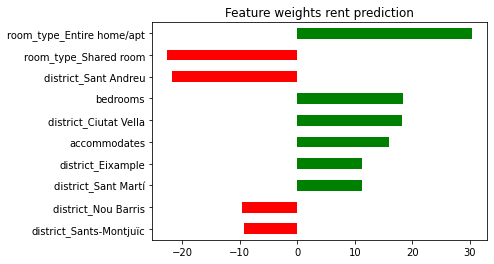

In [10]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=train_data.columns
)

coefs = coefs.sort_values(by=['Coefficients'], key=abs)
coefs = coefs.tail(10)
values = coefs['Coefficients']
color = (values > 0).apply(lambda x: 'g' if x else 'r')
values.plot.barh(color=color) 
plt.title('Feature weights rent prediction');

In [11]:
# Save trained model
pickle.dump(model, open(model_name, 'wb'))

In [12]:
# Load trained model
model = pickle.load(open(model_name, 'rb'))